# Michelin NLP Capstone Project 
### Presented by: Yuvia Cardenas, Justin Evans, Cristina Lucin, and Woody Sims

## Project Overview

This project focuses on building a prediction model for accurately predicting the coding language of a project using examination of GitHub repo Readme files. Our goal is to develop a predictive model utilizing Python and Python libraries and select the most effective model for production. Initially, we are utilizing BeautifulSoup to acquire our data, selecting 1000 repositories tagged with 'Minecraft' from GitHub, taking in all Readme text and repo language information from each repo. After gathering the data, we explore the data through questions and visualizations before developing a model that can tell us: "What language is this repository most likely to be written in?"

## Goals

### Create deliverables:
- READ ME
- Final Report (Jupyter Notebook)
- Functional acquire.py, explore.py, and model.py files
- Acquire data from Michelin Website utilizing Beautiful Soup to scrape restaurant review text
- Prepare and split the data
- Explore the data and produce visualizations encapsulating exploration
- Establish and document baseline
- Fit and train a classification model to predict the programming language of the Repo
- Evaluate the model by comparing its performance on train utilizing accuracy as a measure
- Evaluate the selected model on test data
- Develop and document findings, takeaways, recommendations, and next steps

In [1]:
# Imports

import pandas as pd
import numpy as np
import re
import os

# Webscraping/NLP
import requests
from requests import get
from bs4 import BeautifulSoup
import time
import nltk
import requests
import unicodedata
from nltk.corpus import stopwords

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
import scipy.stats as stats
from scipy.stats import ttest_ind, levene, f_oneway

# Team Imports

import prepare as p
import acquire as a
import explore as e
import model as m
from importlib import reload


# Acquire
- 6,780 Michelin website page URLs were acquired from a Michelin Kaggle Dataset of the current, quarterly Michelin Restaurants in the world (Kaggle Data Acquired 1/18/2023)
- These website pages were scraped utilizing BeautifulSoup utilizing a function called "get_michelin_pages"
- The text from the restaurant review was appended to the original Michelin Dataframe as a column titled "data"
- This dataframe included 6,780 rows before cleaning
- Each row represents a unique restaurant awarded and currently possessing a Michelin guide award designation
- Each column represents a feature of the restaurant, such as name, location, cuisine type, and price level

# Prepare
### Prepare Actions:
- Removed columns not necessary for project goals
- Dropped rows "restaurants" who no longer appear on the Michelin Guide Website (No longer a current Michelin Awardee)
- Recasted columns into different data types as appropriate
- Checked for null values in the data, imputed null values where applicable
- Utilized Regex and string methods and functions to clean restaurant review text
- Renamed columns and applied lowercase text to columns and data to improve readability/usability
- Tokenized review text, removed stopwords, and lemmatized text for exploration and modeling

In [5]:
# Get the data, take a peek
df = a.get_michelin_pages()
df.head()

,name,address,location,price,cuisine,longitude,latitude,phone_number,url,website_url,award,facilities_and_services,data
0,King's Joy,"2 Wudaoying Hutong, Beijing, China Mainland","Beijing, China Mainland",¥¥¥,Vegetarian,116.410004,39.946681,8.610840e+11,https://guide.michelin.com/en/beijing-municipa...,NaN,3 MICHELIN Stars,"Air conditioning,American Express credit card,...","Just a stone’s throw from Yonghe Temple, this ..."
1,Xin Rong Ji (Xinyuan South Road),"1F, East Tower, Genesis Beijing, 8 Xinyuan Sou...","Beijing, China Mainland",¥¥¥¥,Taizhou,116.450148,39.946380,8.610650e+11,https://guide.michelin.com/en/beijing-municipa...,NaN,3 MICHELIN Stars,"Air conditioning,Car park,China UnionPay,Count...",This branch of the chain restaurant opened in ...
2,Taian Table,"101-102, Building No. 1, Garden Office, No.161...","Shanghai, China Mainland",¥¥¥¥,Innovative,121.474049,31.221807,8.617302e+12,https://guide.michelin.com/en/shanghai-municip...,https://taian-table.cn/,3 MICHELIN Stars,"Air conditioning,American Express credit card,...",A fixture on the city’s dining scene since 201...
3,Ultraviolet by Paul Pairet,'somewhere in Shanghai' - meet at Mr & Mrs Bun...,"Shanghai, China Mainland",¥¥¥¥,Innovative,121.485090,31.240358,NaN,https://guide.michelin.com/en/shanghai-municip...,https://uvbypp.cc/,3 MICHELIN Stars,"Air conditioning,American Express credit card,...",This multi-sensory experience at a secret loca...
4,Quince,"470 Pacific Ave., San Francisco, 94133, USA","San Francisco, USA",$$$$,"Contemporary, Californian",-122.403261,37.797505,1.415776e+10,https://guide.michelin.com/en/california/san-f...,http://www.quincerestaurant.com,3 MICHELIN Stars,"Air conditioning,American Express credit card,...","An air of refinement infuses this dining room,..."


In [6]:
# Take a look at some restaurant reviews from our dataframe:
print(f'Kings Joy (Beijing, China) review text: {df.data[0]}')

Kings Joy (Beijing, China) review text: Just a stone’s throw from Yonghe Temple, this serene restaurant is remodelled from a courtyard house and features a glass-roofed dining room. The chef honed his skills at his grandparents’ restaurant of the same name. Only set menus are available; try the classic menu to sample their specialities all at once. Regulars may opt for the solar-term menu that changes every 15 days. Live harp performance befits the restaurant’s classy elegance.


In [7]:
# Take a look at some restaurant reviews from our dataframe:
print(f'La Palme dOr (Cannes, France) review text: {df.data[500]}')

La Palme dOr (Cannes, France) review text: Some places you fall in love with at first sight and La Palme d'Or is one of them. In the fabulous Art Deco setting of the Hotel Martinez, diners look down on the famous promenade of La Croisette and the Bay of Cannes, while savouring the luxury and refinement so beautifully brought together here. Of course, all this would be worth nothing without high-calibre cuisine. No worries on that score: chef Christian Sinicropi, a local man, has matters entirely in hand. At each stage of the "Mouvements" set menu, he homes in on one ingredient, supporting it with elements from its own ecosystem. The result is coherent and sophisticated, right down to the remarkably precise desserts by Julien Ochando. Definitely worthy of a Golden Palm award.


_________________________________

# Exploration

In [8]:
# Splitting our data (56% Train, 24% Validate, 20% Test)
train, validate, test = p.prepare_michelin(df)
train.head(2)

,name,address,location,price,cuisine,longitude,latitude,url,award,facilities_and_services,data,price_level,city,country,clean,lemmatized,sentiment,word_count
6345,gasthaus ödenturm,"am ödenturm 11, cham, 93413, germany","cham, germany",€,"country cooking, mediterranean cuisine",12.703851,49.210919,https://guide.michelin.com/en/bayern/cham/rest...,bib gourmand,"car park,credit card / debit card accepted,gre...","as if straight out of a picture book, this bea...",1,cham,germany,straight picture book beautiful inn stands edg...,straight picture book beautiful inn stand edge...,0.9136,38
6427,weinhaus anker,"obertorstraße 13, marktheidenfeld, 97828, germany","marktheidenfeld, germany",€,"french, country cooking",9.600301,49.845621,https://guide.michelin.com/en/bayern/marktheid...,bib gourmand,"american express credit card,car park,credit c...",a restaurant that is steeped in tradition and ...,1,marktheidenfeld,germany,steeped tradition run great commitment lovely ...,steeped tradition run great commitment lovely ...,0.9186,35


## Question 1: What is the distribution of our target variable (award type)?

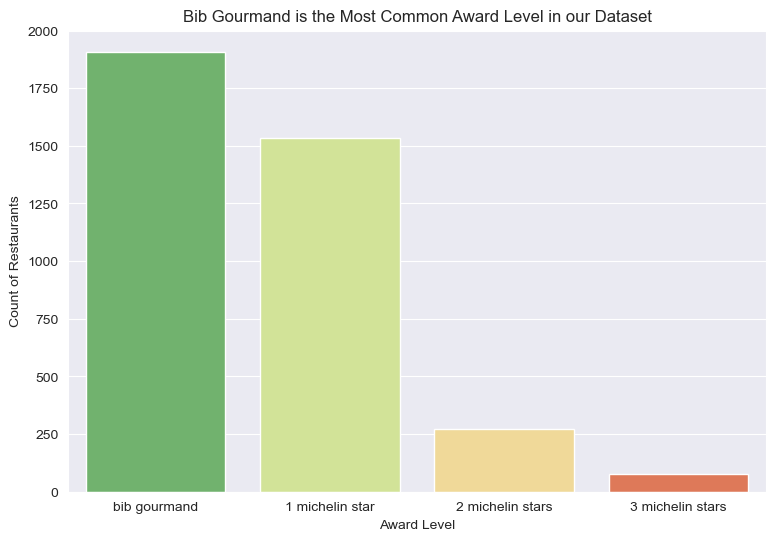

In [15]:
# Generate visuazliation of distribution of target variable
e.get_award_freq(train)

In [16]:
# Establishing Baseline for modeling, with the Mode being 'bib gourmand'
len(train[train.award == 'bib gourmand']) / len(train.award)

0.5030319008700237

## Question 2: What Countries have the most Michelin Restaurants?

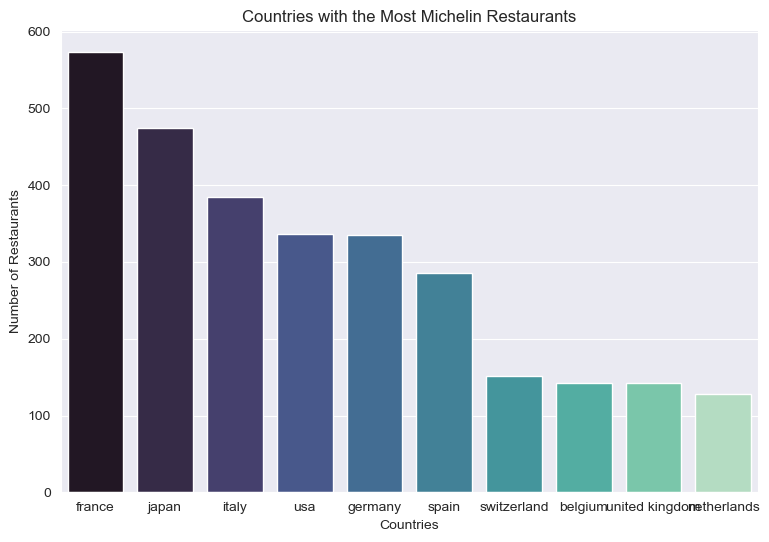

In [17]:
# Generate visualizaion of count of Michelin awardees by country
e.top_10_country_viz(train)

## Question 3: What is the average wordcount of restaurant reviews, by award type?

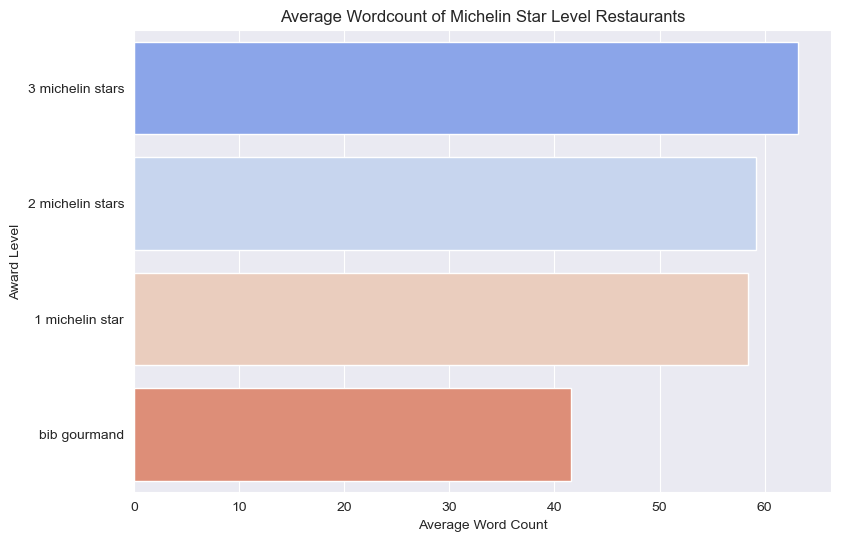

In [18]:
# Generate Visualization of average wordcount by Michelin award category
e.get_wordcount_bar(train)

### We conducted an ANOVA (Analysis of Variance) test to determine if there is a significant difference in review wordcount:

In [19]:
# Generate visualization of wordcount by award category
e.get_anova_wordcount(train)

We reject the null hypothesis. There is sufficient 
               evidence to conclude that the word count is significantly 
               different between award categories.
Test Statistic: 324.58867718184115, P Statistic: 1.4373128353659552e-187


## Question 4: Do three star Michelin restaurants have the highest sentiment score?

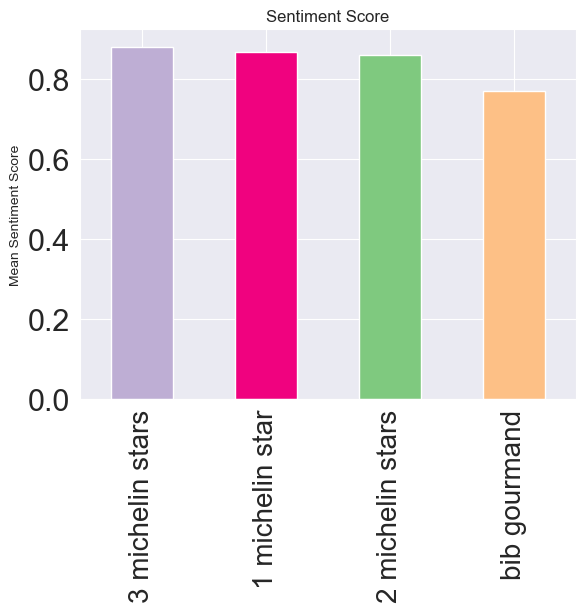

In [21]:
# Generate visualization for sentiment score
e.sentiment_scores_bar(train)

- Sentiment scores for all categories are generally favorable
- Restaurants awarded three (3) Michelin stars had the highest sentiment score

## Question 5: What are the most frequent words used in Michelin Restaurant reviews?

In [ ]:
# Most frequent single words
e.get_ngram_frequency(train.lemmatized, n=1).head(5)

dish          1954
ingredient    1183
also           997
flavour        969
wine           957
dtype: int64

In [ ]:
# Most frequent bigrams
e.get_ngram_frequency(train.lemmatized, n=2).head(5)

wine list       238
la carte        213
tasting menu    142
open kitchen    120
set menu        110
dtype: int64

In [ ]:
# Most frequent trigrams
e.get_ngram_frequency(train.lemmatized, n=3).head(5)

two tasting menu         39
take pride place         35
three tasting menu       31
update september 2020    27
last update september    27
dtype: int64

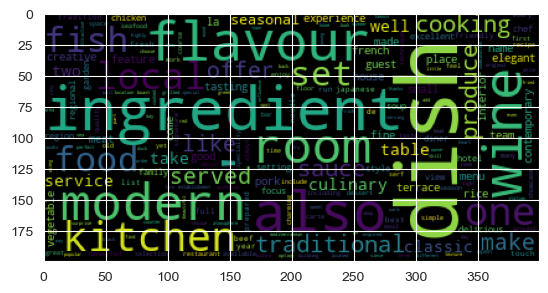

In [ ]:
e.generate_word_cloud(train.lemmatized)

## Exploration Summary

- "Bib Gourmand" Award Level is the most common award category (baseline is 50.3%)
- France has the most Michelin awarded restaurants, followed by Japan, Italy, U.S.A and Germany)
- Restaurants awarded three (3) Michelin stars had reviews with the most words, and Bib Gourmand Restaurants had the fewest word count
- Restaurants awarded three (3) Michelin stars had the highest sentiment score, and Bib Gourmand restaurants had the lowest sentiment score
- "Dish", "Ingredient", "Flavour" are the most common words
- "Wine List", "La Carte", "Tasting Menu" are the most common two-word combinations (bi-grams)
- "Two tasting menu" and "Take Pride Place" ar ethe most common three-word combinations (tri-grams)

________________________________________________________________________________________________________

# Modeling

- We utilized accuracy as the evaluation metric
- We developed three different models using different model types: (Decision Tree, Random Forest, Logistic Regression, eXtreme Gradient Boosting (XGBoost))
- The best application (via Hyperparameter tuning) was selected for evaluation of test data
- We utilized the mode of 'Bib Gourmand' as the baseline (50.3%)

We explored several methods of NLP modeling. We elected to utilize as much useful text as possible. Because this is a multilabel classification project we decided that the large string of text would be more useful for finding differences between reviews by award category rating

We trained several models on our training set without hyperparameter tuning to produce models that were 'Good Enough'.

In [ ]:
# Get Baseline
m.

In [ ]:
# Run modeling function
